In [2]:
from manifold_learning import IMD
import numpy as np
from FastCCM import CCM, CCM_utils
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand,load_csv_dataset,load_traffic_dataset,load_excel_dataset,get_truncated_rossler_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from manifold_learning import imd_nd_smap, imd_1d_smap, imd_nd, imd_nd_2p_smap
import importlib
import seaborn as sns
import scipy.cluster.hierarchy as sch
importlib.reload(imd_nd_smap)
importlib.reload(imd_1d_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [3]:

from matplotlib.colors import LinearSegmentedColormap

def plot_pairwise_arrows_with_direction_gradient(ax,pairwise_matrix, strength_matrix, points, start_color='blue', end_color='red', steps=100):
    """
    Plots arrows between points based on a pairwise matrix, with arrow color as a gradient
    from start_color to end_color and width determined by connection strength. Points are plotted in black.

    Parameters:
    - pairwise_matrix (ndarray): Boolean matrix indicating direction of connections (True/False).
    - strength_matrix (ndarray): Numeric matrix indicating strength of connections.
    - points (ndarray): Coordinates of points as an (N, 2) array.
    - start_color (str): Color of the arrow's start.
    - end_color (str): Color of the arrow's end.
    - steps (int): Number of gradient segments.

    Returns:
    - None
    """

    # Normalize strength matrix for line width scaling
    min_strength = np.min(strength_matrix[strength_matrix > 0])
    max_strength = np.max(strength_matrix)
    normalize_strength = lambda s: (s - min_strength) / (max_strength - min_strength) + 0.1

    # Plot the points in black
    ax.scatter(points[:, 0], points[:, 1], color='black', s=50, zorder=5)

    # Plot the arrows
    for i in range(pairwise_matrix.shape[0]):
        for j in range(pairwise_matrix.shape[1]):
            if pairwise_matrix[i, j]:  # Check if there's a connection
                start = points[i]
                end = points[j]
                strength = strength_matrix[i, j]
                width = normalize_strength(strength)  # Scale the width based on strength
                gradient_arrow(ax, start, end, start_color, end_color, width, steps)

    # Customize plot
    #ax.set_xlim(points[:, 0].min() - 0.5, points[:, 0].max() + 0.5)
    #ax.set_ylim(points[:, 1].min() - 0.5, points[:, 1].max() + 0.5)
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.set_title('Pairwise Connections with Gradient-Colored Arrows and Points')
    plt.grid()
    plt.show()

def gradient_arrow(ax, start, end, start_color, end_color, width, steps):
    """
    Draws a single arrow with a gradient color and adjustable width.

    Parameters:
    - ax: Matplotlib axis object.
    - start (tuple): Starting point (x, y).
    - end (tuple): Ending point (x, y).
    - start_color (str): Start color of the arrow.
    - end_color (str): End color of the arrow.
    - width (float): Width of the arrow lines.
    - steps (int): Number of gradient segments.
    """
    cmap = LinearSegmentedColormap.from_list('gradient', [start_color, end_color])
    for t in np.linspace(0, 1, steps):
        intermediate_start = (1 - t) * np.array(start) + t * np.array(end)
        intermediate_end = (1 - (t + 1 / steps)) * np.array(start) + (t + 1 / steps) * np.array(end)
        ax.plot(
            [intermediate_start[0], intermediate_end[0]],
            [intermediate_start[1], intermediate_end[1]],
            color=cmap(t),
            lw=width*10,
            solid_capstyle='round',
        )


In [4]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [5]:
X = get_truncated_lorenz_rand(400,n_steps=20000,)

exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),10), np.linspace(X[:,2].min(),X[:,2].max(),10))).reshape(2,-1).T

In [6]:

X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]


In [7]:

observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=8) for e in exp_kernel_grid]) for x in X_]).T
#observables[observables < 0.1] = 0
mixing_mat = np.random.normal(size=(observables.shape[1],observables.shape[1]))
observables = observables @ mixing_mat
observables = StandardScaler().fit_transform(observables)

In [8]:
observables_train = observables[10000:]
observables_test = observables[:10000]

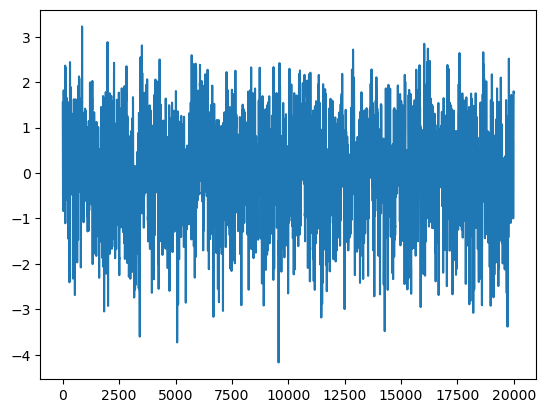

In [9]:
plt.plot(observables[:,0])

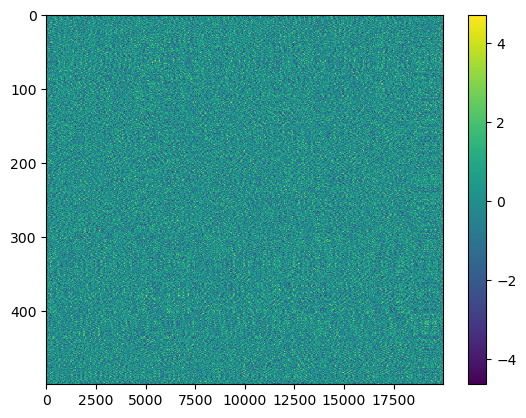

In [10]:
plt.imshow((observables[:].T),aspect="auto",interpolation="nearest")
plt.colorbar()

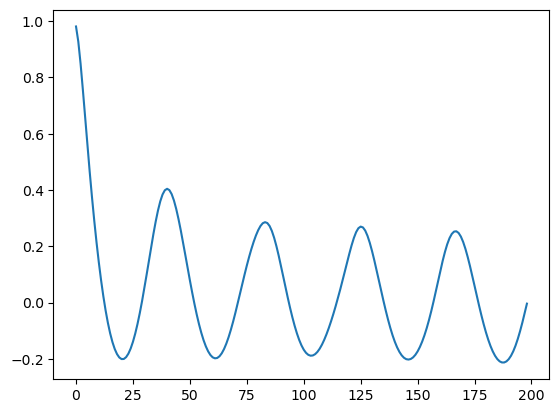

In [9]:
plt.plot(np.mean([[np.corrcoef(observables[k:,i], observables[:-k,i])[1,0] for k in range(1,200)] for i in range(50)],axis=0))

In [22]:
n_exp = 6
n_comp_list = [1,2,3,4,5,6,7,8]
models = []
unmixed_train_all = []
unmixed_test_all = []

for n_comp in n_comp_list:
    for exp in range(n_exp):
        trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=5, n_components=n_comp, subtract_corr=False, device="cuda")

        trainer.fit(observables_train, sample_len=170, library_len=700, 
                exclusion_rad=20, theta=5, tp=30, 
                epochs=300, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3 if n_comp > 3 else None)
        models += [trainer.model]


        unmixed_train = trainer.predict(observables_train)
        unmixed_test = trainer.predict(observables_test)
        unmixed_train_all += [unmixed_train.copy()]
        unmixed_test_all += [unmixed_test.copy()]


Epoch 1/300, Loss: 0.7990
Epoch 2/300, Loss: 0.6439
Epoch 3/300, Loss: 0.5195
Epoch 4/300, Loss: 0.4358
Epoch 5/300, Loss: 0.4252
Epoch 6/300, Loss: 0.3568
Epoch 7/300, Loss: 0.3272
Epoch 8/300, Loss: 0.2960
Epoch 9/300, Loss: 0.2641
Epoch 10/300, Loss: 0.2564
Epoch 11/300, Loss: 0.2453
Epoch 12/300, Loss: 0.2116
Epoch 13/300, Loss: 0.2015
Epoch 14/300, Loss: 0.2120
Epoch 15/300, Loss: 0.1870
Epoch 16/300, Loss: 0.1580
Epoch 17/300, Loss: 0.1674
Epoch 18/300, Loss: 0.1730
Epoch 19/300, Loss: 0.1539
Epoch 20/300, Loss: 0.1526
Epoch 21/300, Loss: 0.1373
Epoch 22/300, Loss: 0.1310
Epoch 23/300, Loss: 0.1288
Epoch 24/300, Loss: 0.1250
Epoch 25/300, Loss: 0.1207
Epoch 26/300, Loss: 0.1154
Epoch 27/300, Loss: 0.1076
Epoch 28/300, Loss: 0.1094
Epoch 29/300, Loss: 0.1074
Epoch 30/300, Loss: 0.1084
Epoch 31/300, Loss: 0.1019
Epoch 32/300, Loss: 0.0985
Epoch 33/300, Loss: 0.0970
Epoch 34/300, Loss: 0.1034
Epoch 35/300, Loss: 0.0957
Epoch 36/300, Loss: 0.0931
Epoch 37/300, Loss: 0.0928
Epoch 38/3

In [11]:
unmixed_train_all_concat = np.load("results/lorenz_unmixed_train_all_concat.npy")
unmixed_test_all_concat = np.load("results/lorenz_unmixed_test_all_concat.npy")

In [23]:
unmixed_train_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_train_all])
unmixed_test_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_test_all])

In [12]:

ccm_unmixed_train = CCM.PairwiseCCM().compute(unmixed_train_all_concat,unmixed_train_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_test = CCM.PairwiseCCM().compute(unmixed_test_all_concat,unmixed_test_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)

ccm_unmixed_train[ccm_unmixed_train<0]=0
ccm_unmixed_test[ccm_unmixed_test<0]=0


In [12]:
observables_train_sel = observables_train[:,np.argsort(np.random.uniform(0,1,size=500))[:70]]

In [13]:
unmixed_xmap_X_train = [np.mean([CCM.PairwiseCCM().compute(unmixed_train_all_concat[[i]],
                                                           observables_train_sel.T[:,:,None],
                                                           1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(unmixed_train_all_concat.shape[0])]
unmixed_xmap_X_train = np.array(unmixed_xmap_X_train).T[0]
unmixed_xmap_X_train[unmixed_xmap_X_train<0]=0



/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


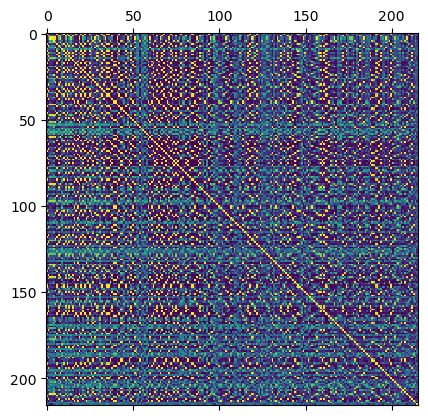

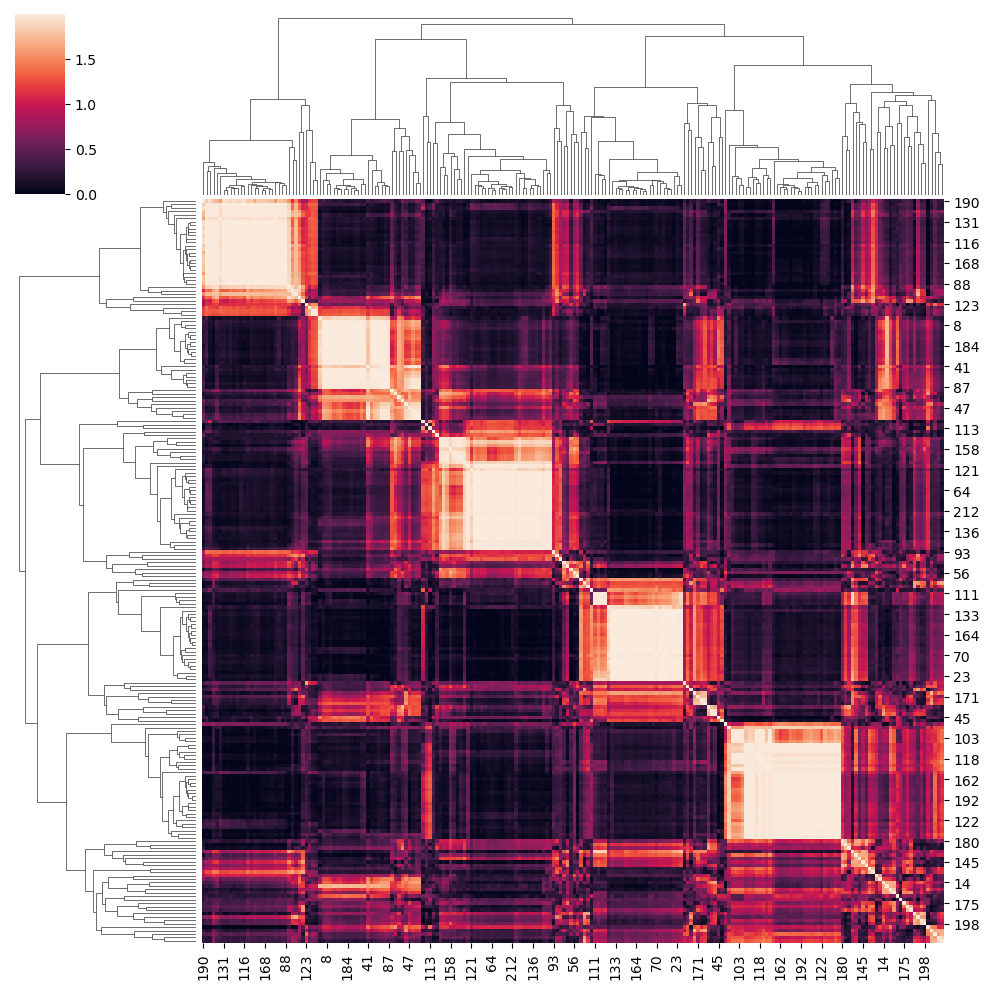

In [16]:


plt.matshow(ccm_unmixed_train,vmin=0,vmax=1)

# Generate the clustermap and get the linkage matrix for the columns
clustermap = sns.clustermap(ccm_unmixed_train + ccm_unmixed_train.T,method="average", col_cluster=True)
col_linkage = clustermap.dendrogram_col.linkage

n_clusters = 7
col_clusters = sch.cut_tree(col_linkage, n_clusters=n_clusters).flatten()

# Initialize a dictionary to store the barycenter variable for each cluster
barycenter_vars = []

# Iterate through each cluster
for cluster in range(n_clusters):
    # Get the indices of columns in this cluster
    cluster_indices = np.where(col_clusters == cluster)[0]
    
    # Extract the submatrix for this cluster
    cluster_matrix = ccm_unmixed_train[np.ix_(cluster_indices, cluster_indices)]
    
    # Calculate the average correlation for each variable in the cluster
    avg_correlations = cluster_matrix.mean(axis=1)
    
    # Find the index of the variable with the highest average correlation
    closest_variable_idx = cluster_indices[np.argmax(avg_correlations)]
    
    # Store the result
    barycenter_vars += [closest_variable_idx]
barycenter_vars = np.array(barycenter_vars)

ccm_unmixed_train_reduced = np.array([[ccm_unmixed_train[col_clusters==j][:,col_clusters==i].mean() for i in range(col_clusters.max()+1)] for j in range(col_clusters.max()+1)])

ccm_unmixed_train_reduced = CCM.PairwiseCCM().compute(unmixed_train_all_concat[barycenter_vars],unmixed_train_all_concat[barycenter_vars],1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_train_reduced[ccm_unmixed_train_reduced<0]=0

unmixed_xmap_X_train_reduced = [np.mean([CCM.PairwiseCCM().compute(unmixed_train_all_concat[[i]],observables_train[:,:X.shape[1]].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in barycenter_vars]
unmixed_xmap_X_train_reduced = np.array(unmixed_xmap_X_train_reduced).T[0]
unmixed_xmap_X_train_reduced[unmixed_xmap_X_train_reduced<0]=0

unmixed_xmap_X_test_reduced = [np.mean([CCM.PairwiseCCM().compute(unmixed_test_all_concat[[i]],observables_test[:,:X.shape[1]].T[:,:,None],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in barycenter_vars]
unmixed_xmap_X_test_reduced = np.array(unmixed_xmap_X_test_reduced).T[0]
unmixed_xmap_X_test_reduced[unmixed_xmap_X_test_reduced<0]=0

X_xmap_unmixed_train_reduced = [np.mean([CCM.PairwiseCCM().compute(np.transpose(utils.get_td_embedding_np(observables_train[:,:62],3,5),(2,0,1))[[i]],unmixed_train_all_concat[barycenter_vars][:,:,[0]],1200,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0) for exp in range(5)] ,axis=0) for i in range(62)]
X_xmap_unmixed_train_reduced = np.array(X_xmap_unmixed_train_reduced).T[0]
X_xmap_unmixed_train_reduced[X_xmap_unmixed_train_reduced<0]=0

/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/iaroslav/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


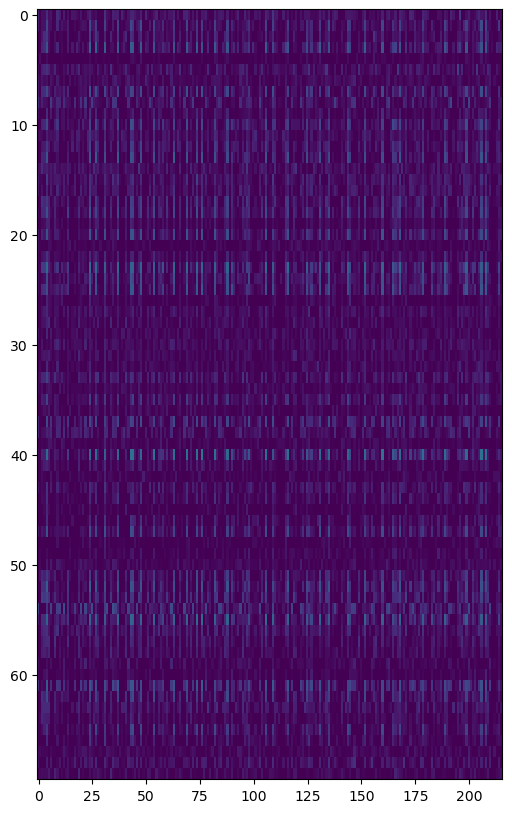

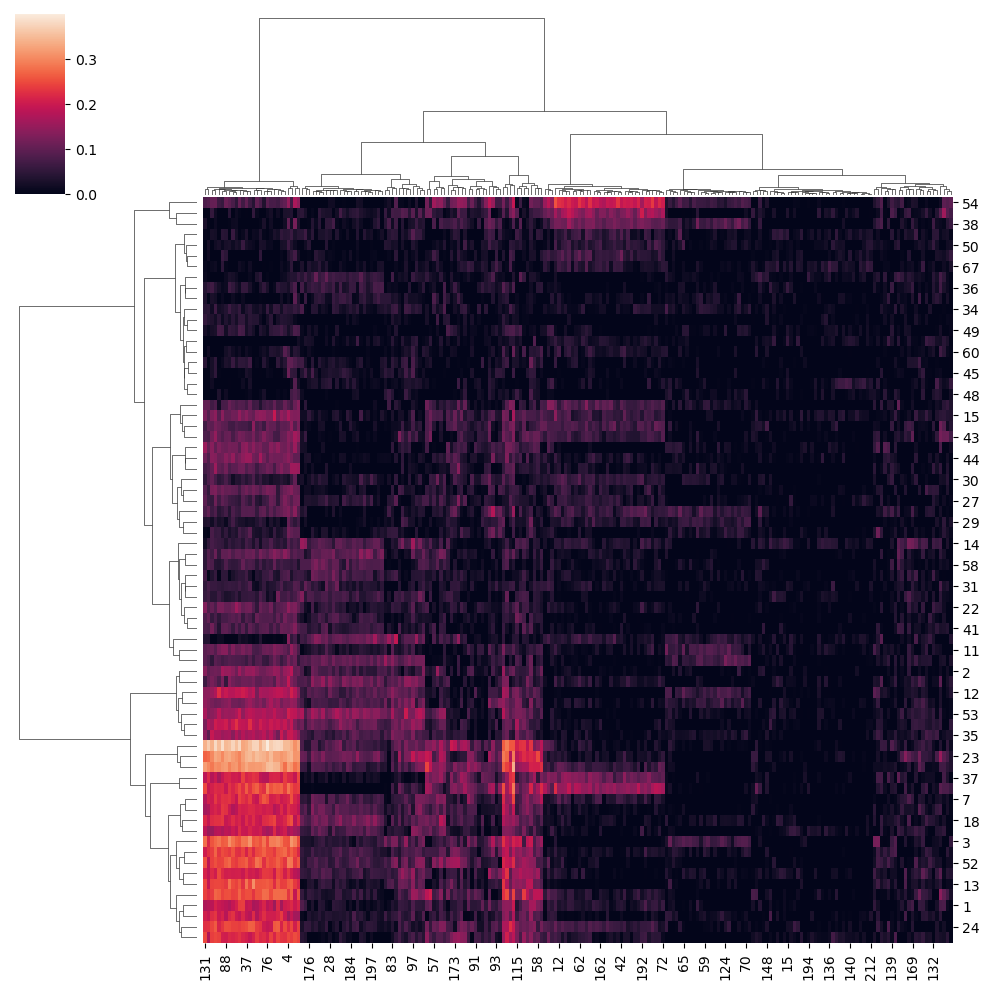

In [40]:
plt.figure(figsize=(6,10))

plt.imshow(unmixed_xmap_X_train,vmin=0,vmax=1,aspect="auto",interpolation="nearest")

sns.clustermap(unmixed_xmap_X_train, method="ward")

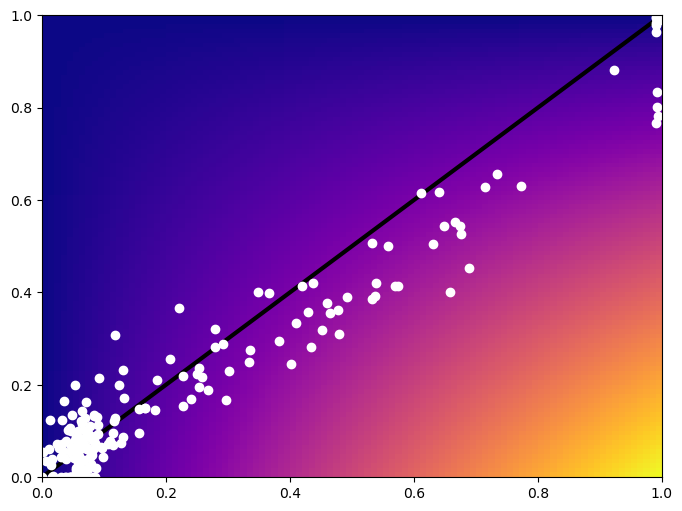

In [16]:
bx = np.linspace(0, 1, 100)
by = np.linspace(1, 0, 100)
gradient = np.outer(by,bx)  

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(gradient, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='plasma')

ax.plot([0, 1], [0, 1], color="black", lw=3)
ax.scatter(ccm_unmixed_train[:,0],ccm_unmixed_train[0],c="white",zorder=2)

In [31]:

import umap
reducer = umap.UMAP(metric='precomputed', n_neighbors=25, min_dist=0.1, n_components=2, random_state=12)
X_umap = reducer.fit_transform(2-(ccm_unmixed_train+ccm_unmixed_train.T))


/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


IndexError: index 6 is out of bounds for axis 0 with size 6

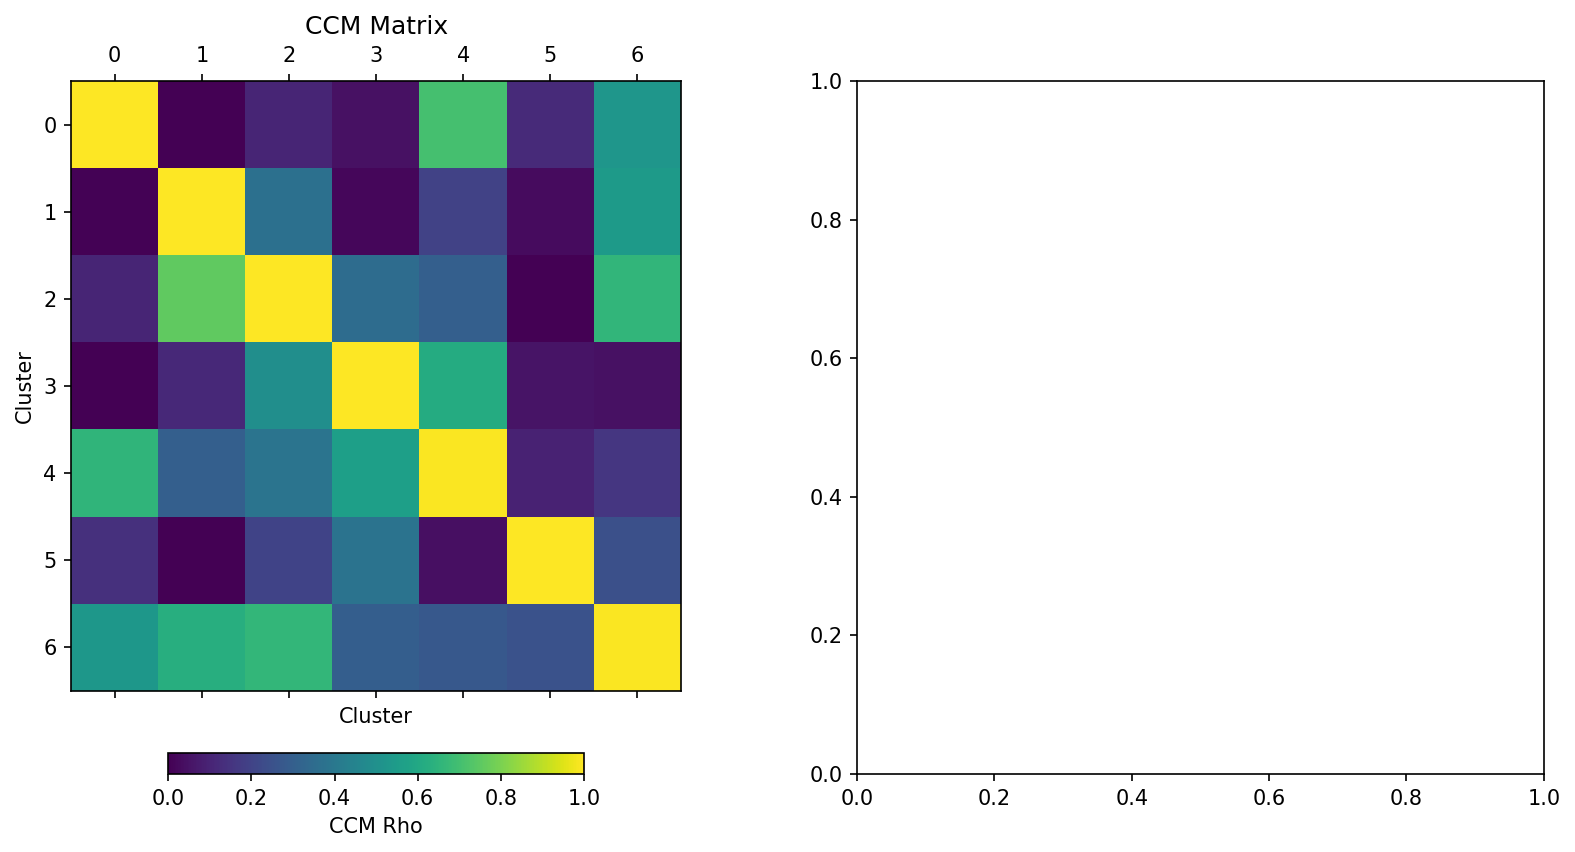

In [46]:
colors = np.array([
    [0.894118, 0.101961, 0.109804],  # Red
    [0.215686, 0.494118, 0.721569],  # Blue
    [0.301961, 0.686275, 0.290196],  # Green
    [0.596078, 0.305882, 0.639216],  # Purple
    [1.000000, 0.498039, 0.000000],  # Orange
    [0.500000, 0.500000, 0.500000],
])
# Create subplots with 2 columns
fig, axes = plt.subplots(1, 2, figsize=(13, 6),dpi=150)  # (1 row, 2 columns)

# Plot the first subplot (matshow)
im = axes[0].matshow(ccm_unmixed_train_reduced, vmax=1, vmin=0)
axes[0].set_title("CCM Matrix")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Cluster")

# Add colorbar for the left subplot
cbar = plt.colorbar(im, ax=axes[0], fraction=0.03, pad=0.09,orientation="horizontal")
cbar.set_label("CCM Rho",)

# Plot the second subplot (scatter and arrows)
scatter_ax = axes[1]
scatter = scatter_ax.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=[colors[i] for i in col_clusters],
    s=150
)
scatter_ax.set_title("UMAP Projection of CCM Matrix Between\nLearned Components")

# Add a custom legend
cluster_labels = ["Clust. 0", "Clust. 1", "Clust. 2", "Clust. 3", "Clust. 4", "Clust. 5"]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label)
           for i, label in enumerate(cluster_labels)]
scatter_ax.legend(handles=handles)
scatter_ax.set_xlabel("UMAP 1")
scatter_ax.set_ylabel("UMAP 2")

# Call the custom function for arrows
plot_pairwise_arrows_with_direction_gradient(
    scatter_ax,
    (ccm_unmixed_train_reduced.T - ccm_unmixed_train_reduced) > 0.1,
    ccm_unmixed_train_reduced.T,
    X_umap[barycenter_vars]
)

# Adjust layout for better appearance
plt.tight_layout()
# Show the plots
plt.show()


In [18]:
density = np.sort(ccm_unmixed_train+ccm_unmixed_train.T,axis=1)[:,-20:-1].mean(axis=1)/2

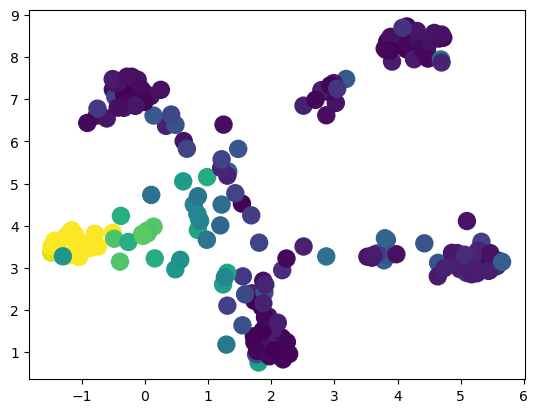

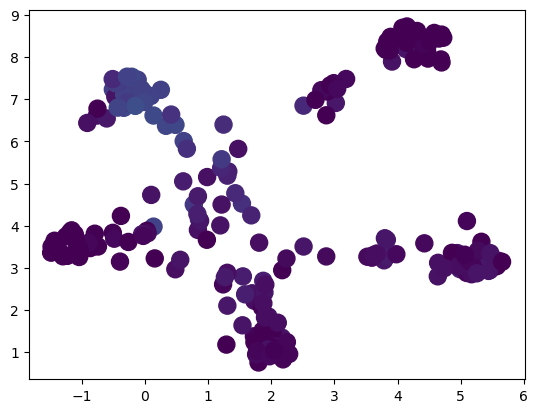

In [19]:

# Plot the results
#plt.scatter(X_umap[:, 0], X_umap[:, 1],c=np.repeat([1,2,3,4,5,6,7,8],np.array([1,2,3,4,5,6,7,8])*6), cmap='viridis', s=50)

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=ccm_unmixed_train[50], cmap='viridis', s=150,vmax=1,vmin=0)
plt.show()
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=unmixed_xmap_X_train[1], cmap='viridis', s=150,vmax=1,vmin=0)

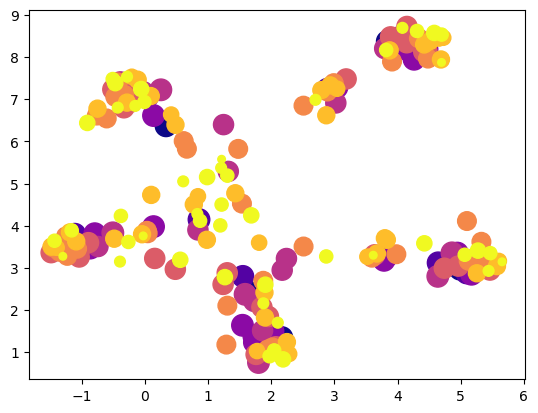

In [20]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=np.repeat([1,2,3,4,5,6,7,8],np.array([1,2,3,4,5,6,7,8])*6), cmap='plasma', s=30 * np.repeat([1,2,3,4,5,6,7,8],np.array([1,2,3,4,5,6,7,8])*6)[::-1])

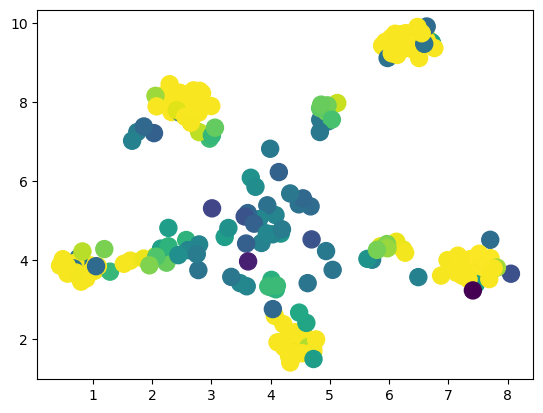

In [34]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=density, cmap='viridis', s=150,vmax=1)
plt.show()

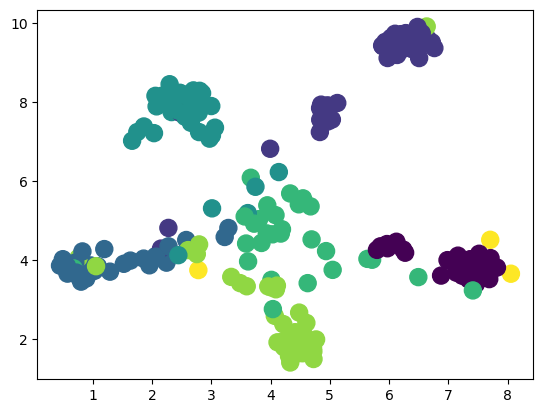

In [49]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],c=col_clusters, cmap='viridis', s=150)
plt.show()

Text(0, 0.5, 'UMAP 2')

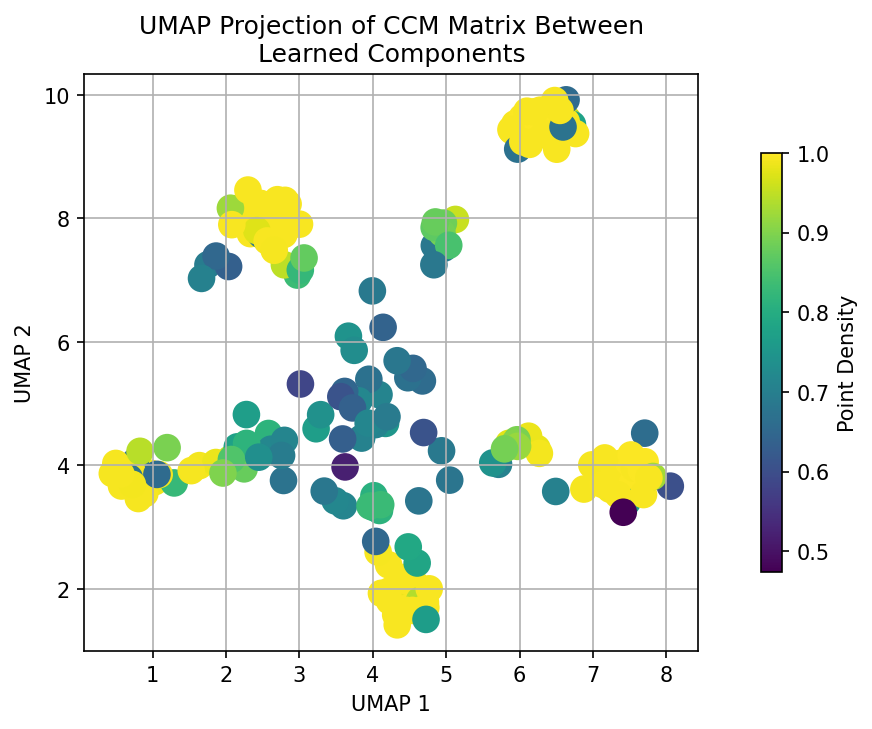

In [50]:
plt.figure(figsize=(6,5),dpi=150)
plt.grid()
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=density, cmap='viridis', s=150,vmax=1)
plt.colorbar(fraction=0.03, pad=0.09,label="Point Density")
plt.title("UMAP Projection of CCM Matrix Between\nLearned Components")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

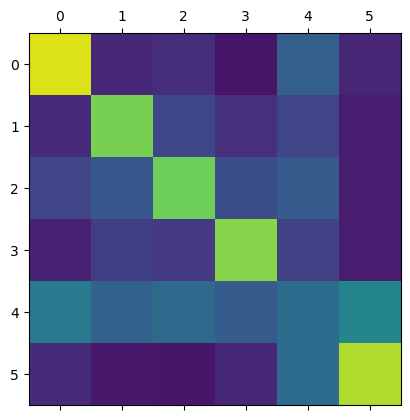

In [131]:
ccm_unmixed_train_reduced = np.array([[ccm_unmixed_train[col_clusters==j][:,col_clusters==i].mean() for i in range(col_clusters.max()+1)] for j in range(col_clusters.max()+1)])

plt.matshow(ccm_unmixed_train_reduced,vmax=1,vmin=0)

In [73]:
monster_matrix = np.abs(np.concatenate([np.concatenate([ccm_unmixed_train,unmixed_xmap_X_train]),np.concatenate([unmixed_xmap_X_train.T, np.corrcoef(observables_train_sel.T)])],axis=1))
reducer = umap.UMAP(metric='precomputed', n_neighbors=20, min_dist=0.5, n_components=2, random_state=12,)
X_umap = reducer.fit_transform(2-monster_matrix-monster_matrix.T)

/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/iaroslav/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


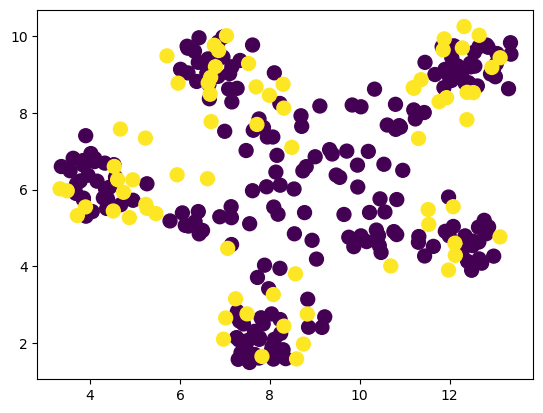

In [74]:

plt.scatter(X_umap[:, 0], X_umap[:, 1],cmap='viridis', c=([0] * ccm_unmixed_train.shape[0] + [1] * unmixed_xmap_X_train.shape[0]),s=100,vmax=1,vmin=0)
#plt.scatter(X_umap[1, 0], X_umap[1, 1],cmap='viridis', c="red",s=100,vmax=1,vmin=0)